<h1  style="color: rgba(80, 172, 20, 1);">Detecção de Ataque DDoS com Aprendizado de Máquina Não Supervisionado Utilizando Isolation Forest</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, when
import csv

<p>Todos os datasets estão disponíveis no link: <a>https://www.unb.ca/cic/datasets/ddos-2019.html</a></p>

<p>Foi utilizado a ferramenta Apache Spark para poder fazer a leitura de todos os arquivos .csv do dataset sem sobrecarregar a memória RAM, criando a sessão spark no código abaixo.
Pelo fato de o pyspark ser uma biblioteca diferente do pandas, foram realizadas algumas mudanças no código para o melhor funcionamento.</p>

In [2]:
spark = SparkSession.builder \
    .appName("DDoS Detection") \
    .master("local[*]") \
    .config("spark.driver.memory", "6g") \
    .getOrCreate()

files = [
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_UDP.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_DNS.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_NTP.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/Syn.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_LDAP.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/UDPLag.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_SSDP.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_SNMP.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_NetBIOS.csv",
    "C:/data_science_iforest_ddos/dataset/training/CSV-01-12/01-12/DrDoS_MSSQL.csv"
]

df = spark.read.csv(files, header=True, inferSchema=True)

df = df.drop('Unnamed: 0')

In [3]:
# df.show(5)

<p>É importado um dataset do CIC-DDoS2019 não utilizado no processo de treinamento, apenas para a validação externa</p>

In [4]:
files_test = [
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/UDP.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/Syn.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/UDPLag.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/LDAP.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/Portmap.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/LDAP.csv',
    'C:/data_science_iforest_ddos/dataset/tests/CSV-03-11/03-11/NetBIOS.csv'

]

In [5]:
df_test = spark.read.csv(files_test, header=True, inferSchema=True)

In [6]:
df_test = df_test.drop('Unnamed: 0')

In [7]:
# df_test.show(5)

<h2 style="color: rgb(100, 200, 34);">Análise Exploratória dos dados do dataset</h2>

<p>Diversas linhas de código foram comentadas pois são apenas linhas de análise, a fim de facilitar e agilizar o processamento.</p>

In [8]:
# df.columns

In [9]:
# df_test.columns

In [10]:
# df_test.count()

<p>É feita uma limpeza nos nomes das colunas, por apresentarem um espaço extra inicial, facilitando a leitura e criação de código. Ex: ' Label' -> 'Label'</p>

In [11]:
new_columns = [col_name.strip() for col_name in df.columns]
for old_name, new_name in zip(df.columns, new_columns):
    df = df.withColumnRenamed(old_name, new_name) #type: ignore

new_columns_test = [col_name.strip() for col_name in df_test.columns]
for old_name, new_name in zip(df_test.columns, new_columns_test):
    df_test = df_test.withColumnRenamed(old_name, new_name) #type: ignore


In [12]:
# df.columns

<p>Verificação de valores nulos no dataset</p>

In [13]:
# df.isna().sum()

In [14]:
# df_test.isna().sum()

In [15]:
# df.dtypes

<p>Verificação de quantos valores existem por classe (Label)</p>

In [16]:
# df.groupBy("Label").count().show()

In [17]:
# df_test.groupBy("Label").count().show()

<h2 style="color: rgb(100, 200, 34);">Diminuindo o Dataset de Teste</h2>

<p>Foi feita uma diminuição dos dados de treino a fim de manter a proporção dos dados de treino.</p>

<p>Aqui separamos os dados benignos e os malignos em 2 datasets</p>

In [18]:
df_test_benign = df_test[df_test['Label'] == 'BENIGN']
df_test_benign.show()

+--------------------+--------------+-----------+--------------+----------------+--------+--------------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------------+-------------------+------------------+------------------+------------+------------+-------------+-----------------+------------------+-----------+-----------+-------------+------------------+------------------+-----------+-----------+-------------+-------------+-------------+-------------+-----------------+-----------------+-------------------+-------------------+-----------------+-----------------+------------------+------------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------

In [19]:
df_test_malign = df_test[df_test['Label'] != 'BENIGN']

In [20]:
# df_test.show(3)

In [21]:
# df_test_malign.count()

In [22]:
# df_test_benign.count()

<p>A quantidade de ataques sera calculado a partir dessa proporção</p>

In [23]:
n_attacks = df_test_benign.count() / 4
n_attacks = int(n_attacks)

In [24]:
n_attacks

14823

<p>Os dados malignos sofrerão uma diminuição utilizando a função sample</p>

In [25]:
df_test_sample = df_test_malign.orderBy(rand(seed=42)).limit(n_attacks)

In [26]:
# df_test_sample.count()

In [27]:
df_final = df_test_benign.union(df_test_sample)

<p>Após a diminuição os datasets são concatenados novamente</p>

In [28]:
# df_final.count()

<h2 style="color: rgb(100, 200, 34);">Diminuindo o Dataset de Treino</h2>

<p>O dataset apresenta uma discrepância muito grande no total de valores benignos e os ataques, com uma quantidade muito maior de ataques do que valores normais. Porém, para treinar corretamente o iForest, a proporção deveria ser contrária, com muito mais dados benignos do que ataques, pois o algoritmo irá classificar como anomalia o dado que tiver menor quantidade e para verificação de uma rede normal, onde há muitos mais dados benignos do que malignos. Logo a proporção deverá ser mudado através dos códigos abaixo.</p>

<p>Aqui serão feitos os mesmos processos dos dados de teste, mas com algumas mudanças</p>

In [29]:
df_benign = df[df['Label'] == 'BENIGN']

In [30]:
# df_benign.show(3)

In [31]:
benigns = df_benign.count()

In [32]:
benigns

31616

In [33]:
n_attacks_train = benigns / 4
n_attacks_train = int(n_attacks_train)

In [34]:
n_attacks_train

7904

In [35]:
df_malign_train = df[df['Label'] != 'BENIGN']

In [36]:
# df_malign_train.groupBy("Label").count().show()

<p>Aqui é mantido a proporção dos ataques, sendo os que mais possuem ataques continuarão com mais valores ao final da diminuição.</p>

In [37]:
count_dns = df_malign_train.filter(col('Label') == 'DrDoS_DNS').count()
print(count_dns)

5071011


In [38]:
count_udp = df_malign_train.filter(col('Label') == 'DrDoS_UDP').count()
print(count_udp)

3134645


In [39]:
count_ntp = df_malign_train.filter(col('Label') == 'DrDoS_NTP').count()
print(count_ntp)

1202642


In [40]:
count_syn = df_malign_train.filter(col('Label') == 'Syn').count()
print(count_syn)

1582289


In [41]:
count_ldap = df_malign_train.filter(col('Label') == 'DrDoS_LDAP').count()
print(count_ldap)

2179930


In [42]:
count_udplag = df_malign_train.filter(col('Label') == 'UDP-lag').count()
print(count_udplag)

366461


In [43]:
count_mssql = df_malign_train.filter(col('Label') == 'DrDoS_MSSQL').count()
print(count_mssql)

4522492


In [44]:
count_netbios = df_malign_train.filter(col('Label') == 'DrDoS_NetBIOS').count()
print(count_netbios)

4093279


In [45]:
count_snmp = df_malign_train.filter(col('Label') == 'DrDoS_SNMP').count()
print(count_snmp)

5159870


In [46]:
count_ssdp = df_malign_train.filter(col('Label') == 'DrDoS_SSDP').count()
print(count_ssdp)

2610611


In [47]:
total_attacks = count_ldap + count_udp + count_ntp + count_dns + count_syn + count_udplag + count_mssql + count_netbios + count_snmp + count_ssdp
total_attacks

29923230

<p>Cálculo da proporção de cada ataque baseado em seu protocolo.</p>

In [48]:
dns_frac = count_dns / total_attacks
udp_frac = count_udp / total_attacks
ntp_frac = count_ntp / total_attacks
syn_frac = count_syn / total_attacks
ldap_frac = count_ldap / total_attacks
udplag_frac = count_udplag / total_attacks
mssql_frac = count_mssql / total_attacks
netbios_frac = count_netbios / total_attacks
snmp_frac = count_snmp / total_attacks
ssdp_frac = count_ssdp / total_attacks

In [49]:
# print('DNS: ', dns_frac, '\nUDP: ', udp_frac, '\nNTP: ', ntp_frac, '\nSYN: ', syn_frac, '\nLDAP: ', ldap_frac, '\nUDP Lag: ', udp_frac)

<p>Filtragem do dataset baseado em sua proporção.</p>

In [50]:
dns_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_DNS').orderBy(rand(seed=42)).limit(int(n_attacks_train * dns_frac))
)
udp_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_UDP').orderBy(rand(seed=42)).limit(int(n_attacks_train * udp_frac))
)
ntp_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_NTP').orderBy(rand(seed=42)).limit(int(n_attacks_train * ntp_frac))
)
syn_sample = (
    df_malign_train.filter(col('Label') == 'Syn').orderBy(rand(seed=42)).limit(int(n_attacks_train * syn_frac))
)
ldap_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_LDAP').orderBy(rand(seed=42)).limit(int(n_attacks_train * ldap_frac))
)
udplag_sample = (
    df_malign_train.filter(col('Label') == 'UDP-lag').orderBy(rand(seed=42)).limit(int(n_attacks_train * udplag_frac))
)
mssql_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_MSSQL').orderBy(rand(seed=42)).limit(int(n_attacks_train * mssql_frac))
)
netbios_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_NetBIOS').orderBy(rand(seed=42)).limit(int(n_attacks_train * netbios_frac))
)
snmp_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_SNMP').orderBy(rand(seed=42)).limit(int(n_attacks_train * snmp_frac))
)
ssdp_sample = (
    df_malign_train.filter(col('Label') == 'DrDoS_SSDP').orderBy(rand(seed=42)).limit(int(n_attacks_train * ssdp_frac))
)

In [51]:
# print('DNS: ', dns_sample.count(), '\nUDP: ', udp_sample.count(), '\nNTP: ', ntp_sample.count(), '\nSYN: ', syn_sample.count(), '\nLDAP: ', ldap_sample.count(), '\nUDP LAG: ', udplag_sample.count())

<p>Concatenação dos datasets.</p>

In [52]:
df_attacks = dns_sample.union(udp_sample) \
                        .union(ntp_sample) \
                        .union(syn_sample) \
                        .union(ldap_sample) \
                        .union(udplag_sample) \
                        .union(mssql_sample) \
                        .union(netbios_sample) \
                        .union(snmp_sample) \
                        .union(ssdp_sample) 

In [53]:
# df_attacks.count()

In [54]:
df_train_sampled = df_benign.union(df_attacks) 

In [55]:
# df_train_sampled.groupBy("Label").count().show()

In [56]:
# df_train_sampled.count()

In [57]:
# df_train_sampled.show(3)

<p>Criação de arquivos .csv dos datasets em pyspark para poder transformá-los em Pandas posteriormente.</p>

In [58]:
with open("C:/data_science_iforest_ddos/dataset_created/df_train_sampled.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(df_train_sampled.columns)
    for row in df_train_sampled.collect():
        writer.writerow(row)


In [59]:
with open("C:/data_science_iforest_ddos/dataset_created/df_test_sampled.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(df_final.columns)
    for row in df_final.collect():
        writer.writerow(row)

<h2  style="color: rgb(100, 200, 34);">Retirar Colunas/Features não importantes</h2> 

<p>Agora, os arquivos .csv criados anteriormente são transformados para Pandas para facilitar a leitura, processamento e treinamento do modelo.</p>

In [60]:
df_train_pandas = pd.read_csv(r'C:\data_science_iforest_ddos\dataset_created\df_train_sampled.csv')
df_test_pandas = pd.read_csv(r'C:\data_science_iforest_ddos\dataset_created\df_test_sampled.csv')

C:\Users\talle\AppData\Local\Temp\ipykernel_12956\2476059777.py:2: DtypeWarning: Columns (84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_pandas = pd.read_csv(r'C:\data_science_iforest_ddos\dataset_created\df_test_sampled.csv')


In [61]:
df_train_pandas.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,192.168.10.50-192.168.50.8-22-59643-6,192.168.50.8,59643,192.168.10.50,22,6,2018-12-01 11:37:02.186488,1,2,0,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,1,BENIGN
1,192.168.50.6-23.194.142.15-57664-443-6,192.168.50.6,57664,23.194.142.15,443,6,2018-12-01 11:37:03.069132,266,5,0,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,BENIGN
2,192.168.50.6-23.194.142.15-57664-443-6,192.168.50.6,57664,23.194.142.15,443,6,2018-12-01 11:37:03.069399,20637,1,5,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0,BENIGN
3,192.168.50.6-23.194.142.15-57664-443-6,23.194.142.15,443,192.168.50.6,57664,6,2018-12-01 11:37:03.090080,148,1,2,...,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,1,BENIGN
4,192.168.50.254-224.0.0.5-0-0-0,192.168.50.254,0,224.0.0.5,0,0,2018-12-01 11:37:03.267708,113580323,42,0,...,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0,0,BENIGN


In [62]:
df_train_pandas['Label'].value_counts()

Label
BENIGN           31616
DrDoS_SNMP        1362
DrDoS_DNS         1339
DrDoS_MSSQL       1194
DrDoS_NetBIOS     1081
DrDoS_UDP          827
DrDoS_SSDP         689
DrDoS_LDAP         575
Syn                417
DrDoS_NTP          317
UDP-lag             96
Name: count, dtype: int64

In [63]:
df_test_pandas.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,192.168.10.50-192.168.50.8-21-60319-6,192.168.50.8,60319,192.168.10.50,21,6,2018-11-03 10:42:57.648027,9015834,6,0,...,0.000000,3009701.0,3009701.0,6.006131e+06,0.000000e+00,6006131.0,6006131.0,0,1,BENIGN
1,192.168.50.253-224.0.0.5-0-0-0,192.168.50.253,0,224.0.0.5,0,0,2018-11-03 10:42:57.699191,113498356,52,0,...,28.810772,106.0,5.0,9.458180e+06,3.307888e+05,9909241.0,9048680.0,0,0,BENIGN
2,192.168.50.6-23.194.142.213-55650-443-6,192.168.50.6,55650,23.194.142.213,443,6,2018-11-03 10:42:58.393445,56638650,26,24,...,107279.792294,289179.0,20805.0,9.365196e+06,1.338180e+06,10010988.0,6649735.0,0,0,BENIGN
3,192.168.50.6-4.2.2.4-52485-53-17,192.168.50.6,52485,4.2.2.4,53,17,2018-11-03 10:42:58.393567,21234,2,2,...,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0,BENIGN
4,192.168.50.6-72.21.91.29-55656-80-6,192.168.50.6,55656,72.21.91.29,80,6,2018-11-03 10:42:58.402896,56653775,14,12,...,188.881974,28417.0,27941.0,9.414137e+06,1.452976e+06,10019426.0,6448290.0,0,0,BENIGN


<p>Aqui trocamos os valores 'BENIGN' e o nome do ataque para valores binários (0 e 1) a fim de falicitar no processo de aprendizagem do algoritmo</p>

In [64]:
df_test_pandas['Label'] = df_test_pandas['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [65]:
df_train_pandas['Label'] = df_train_pandas['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [66]:
df_test_pandas['Label'].value_counts()

Label
0    59295
1    14823
Name: count, dtype: int64

In [67]:
df_train_pandas['Label'].value_counts()

Label
0    31616
1     7897
Name: count, dtype: int64

In [68]:
df_train_pandas['SimillarHTTP'].value_counts()

SimillarHTTP
0                                                                                             38331
ocsp.pki.goog/GTSGIAG3                                                                          180
ocsp.digicert.com/                                                                              148
drmokhberi.ca/favicon.ico                                                                        38
detectportal.firefox.com/success.txt                                                             32
                                                                                              ...  
en.drshno.com/wp-content/uploads/2016/01/lice-treatment-and-prevention-250x250-180x180.jpg        1
en.drshno.com/wp-content/uploads/2016/01/drshno-175x180.png                                       1
en.drshno.com/wp-content/uploads/2016/01/a4-1-180x180.jpg                                         1
en.drshno.com/wp-content/uploads/2016/01/david-beckham-80x80.jpg                       

<p>Retirar colunas de identificação</p>

In [69]:
columns_drop = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp', 'SimillarHTTP']
df_train_pandas = df_train_pandas.drop(columns=columns_drop)

In [70]:
df_test_pandas = df_test_pandas.drop(columns=columns_drop)

In [71]:
df_train_pandas.shape

(39513, 80)

In [72]:
pd.set_option('display.max_columns', None)

In [73]:
df_train_pandas.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
0,6,1,2,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,56,0,2.000000e+06,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.0,0.0,56,0,0,0,0,0,0,2,0,0,0,8192,-1,0,28,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1,0
1,6,266,5,0,154.0,0.0,46.0,0.0,30.8,18.780309,0.0,0.0,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,1.310000e+02,263.0,1.0,266.0,6.650000e+01,1.310000e+02,263.0,1.0,0.0,0.00,0.0,0.0,0.0,1,0,0,0,100,0,1.879699e+04,0.000000,0.0,46.0,33.333333,17.907168,320.666667,0,0,1,0,0,1,0,0,0.0,40.000000,30.8,0.0,100,0,0,0,0,0,0,5,154,0,0,256,-1,3,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0
2,6,20637,1,5,0.0,62.0,0.0,0.0,0.0,0.000000,31.0,0.0,12.4,16.979399,3004.312642,2.907399e+02,4.127400e+03,9.226352e+03,20632.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,5.0,1.25,0.5,2.0,1.0,0,0,0,0,20,100,4.845666e+01,242.283278,0.0,31.0,8.857143,15.126451,228.809524,0,0,0,0,0,1,1,0,5.0,10.333333,0.0,12.4,20,0,0,0,0,0,0,1,0,5,62,256,254,0,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0,0
3,6,148,1,2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,1.032376e+02,147.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,1.00,0.0,1.0,1.0,0,0,0,0,20,40,6.756757e+03,13513.513514,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,1,1,0,2.0,0.000000,0.0,0.0,20,0,0,0,0,0,0,1,0,2,0,254,0,0,20,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1,0
4,0,113580323,42,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,4.229563e+06,9958914.0,1.0,113580323.0,2.770252e+06,4.229563e+06,9958914.0,1.0,0.0,0.00,0.0,0.0,0.0,0,0,0,0,0,0,3.697824e-01,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.0,0.0,0,0,0,0,0,0,0,42,0,0,0,-1,-1,0,0,346264.25,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0,0


In [74]:
df_train_pandas.dtypes

Protocol                         int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets    float64
                                ...   
Idle Std                       float64
Idle Max                       float64
Idle Min                       float64
Inbound                          int64
Label                            int64
Length: 80, dtype: object

<h2 style="color: rgb(100, 200, 34);">Separando as variáveis de entrada (X) e saída (y)</h2>

<p>Para esse projeto foi escolhido treinar o Isolation Forest apenas com os dados benignos e apenas verificar os malignos ao final.</p>
<p style="font-weight: bold;">Por que treinar a IA apenas com dados benignos?</p>
<p>Pois o modelo aprende corretamente o comportamento normal e permite que as anomalias aparecam como desvio, a fim de evitar confundir o modelo</p>

In [75]:
df_benign = df_train_pandas[df_train_pandas['Label'] == 0]
df_malign = df_train_pandas[df_train_pandas['Label'] == 1]

In [76]:
X_benign = df_benign.drop('Label', axis=1)
y_benign = df_benign['Label']

In [77]:
X_test_final = df_test_pandas.drop('Label', axis=1)
y_test_final = df_test_pandas['Label']

<h2  style="color: rgb(100, 200, 34);">Análise de Variância</h2>

<p>Aqui será feito a análise de variância, onde será calculado a variância de cada feature e verificando quais apresentam menos variância, sendo assim removidas do dataset, pois features com pouca variação tendem a não serem importantes para o treinamento do algoritmo</p>

In [78]:
X_benign.dtypes.to_list()

[dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('int64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('fl

In [79]:
X_benign.max().to_list()

[17.0,
 119995906.0,
 5063.0,
 4602.0,
 15266416.0,
 10993758.0,
 32120.0,
 2020.0,
 3015.2905392059947,
 2221.556055317442,
 37960.0,
 1460.0,
 5011.060158910329,
 7045.095259550461,
 inf,
 inf,
 36337109.66666666,
 62937575.51667919,
 119948019.0,
 12348234.0,
 119995906.0,
 28166404.0,
 56020637.66705328,
 119948019.0,
 12348234.0,
 119841028.0,
 54505582.0,
 77082530.46101172,
 109011162.0,
 249.0,
 1.0,
 0.0,
 0.0,
 0.0,
 101260.0,
 147280.0,
 3000000.0,
 2000000.0,
 1460.0,
 37960.0,
 4023.9453551912575,
 6616.562066006961,
 43778893.573322296,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 23.0,
 4025.778587699317,
 3015.290539206005,
 5011.060158910329,
 101260.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5063.0,
 15266416.0,
 4602.0,
 10993758.0,
 65535.0,
 65535.0,
 5043.0,
 1480.0,
 13101141.0,
 11005624.902538748,
 19416375.0,
 13101141.0,
 119219447.0,
 66002917.44011336,
 119219447.0,
 119219447.0,
 1.0]

In [80]:
X_test_final.max().to_list()

[17.0,
 119997515.0,
 86772.0,
 31700.0,
 208524.0,
 58429504.0,
 3625.0,
 2131.0,
 2131.0,
 1448.583031793483,
 3627.0,
 1460.0,
 1850.7692307692307,
 1374.4294667149563,
 inf,
 inf,
 38912105.0,
 64659444.17484788,
 117569202.0,
 38912105.0,
 119997515.0,
 39205448.0,
 67905822.6733472,
 117616338.0,
 38912105.0,
 119943719.0,
 39211146.66666667,
 67915693.05354926,
 117633434.0,
 157.0,
 1.0,
 0.0,
 0.0,
 0.0,
 429016.0,
 634024.0,
 3000000.0,
 2000000.0,
 1472.0,
 3627.0,
 1721.142857142857,
 1293.9065486715635,
 1674194.1566951573,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 15.0,
 2208.0,
 2131.0,
 1850.7692307692307,
 429016.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 86772.0,
 208524.0,
 31700.0,
 58429504.0,
 65535.0,
 65535.0,
 18766.0,
 1480.0,
 40507998.0,
 10637562.388212468,
 40507998.0,
 40507998.0,
 117569202.0,
 69614023.38328542,
 117569202.0,
 117569202.0,
 1.0]

<p>Troca valores infinitos (ou com valores muito altos) por NaN, e posteriormente troca-se o NaN pela media da coluna</p>

In [81]:
X_benign.replace([np.inf, -np.inf], np.nan, inplace=True)

In [82]:
X_benign.fillna(X_benign.mean(), inplace=True)

In [83]:
X_test_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [84]:
X_test_final.fillna(X_test_final.mean(), inplace=True)

<p>Realiza o calculo de variancia no dataset</p>

In [85]:
variance = VarianceThreshold(threshold=0.01)
X_variance_benign = variance.fit_transform(X_benign)

In [86]:
X_variance_benign   

array([[6.0000e+00, 1.0000e+00, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.0000e+00, 2.6600e+02, 5.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+00, 2.0637e+04, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.7000e+01, 2.0565e+04, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0000e+00, 5.7117e+04, 6.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.7000e+01, 2.0594e+04, 2.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], shape=(31616, 66))

<p>variance.get_support(): Retorna um array booleano, indicando quais colunas passaram no filtro de variância</p>

In [87]:
variance_columns = X_benign.columns[variance.get_support()]

In [88]:
X_variance_df = pd.DataFrame(X_variance_benign, columns=variance_columns, index=X_benign.index)

In [89]:
X_variance_df.shape

(31616, 66)

In [90]:
X_variance_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,RST Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.000000e+00,0.000000e+00,1.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,56.0,0.0,2.000000e+06,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,56.0,2.0,0.0,0.0,0.0,8192.0,-1.0,0.0,28.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1.0
1,6.0,266.0,5.0,0.0,154.0,0.0,46.0,0.0,30.8,18.780309,0.0,0.0,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,1.310000e+02,263.0,1.0,266.0,6.650000e+01,1.310000e+02,263.0,1.0,0.0,0.00,0.0,0.0,0.0,1.0,100.0,0.0,1.879699e+04,0.000000,0.0,46.0,33.333333,17.907168,320.666667,1.0,0.0,1.0,0.0,0.0,40.000000,30.8,0.0,100.0,5.0,154.0,0.0,0.0,256.0,-1.0,3.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0
2,6.0,20637.0,1.0,5.0,0.0,62.0,0.0,0.0,0.0,0.000000,31.0,0.0,12.4,16.979399,3004.312642,2.907399e+02,4.127400e+03,9.226352e+03,20632.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,5.0,1.25,0.5,2.0,1.0,0.0,20.0,100.0,4.845666e+01,242.283278,0.0,31.0,8.857143,15.126451,228.809524,0.0,0.0,1.0,1.0,5.0,10.333333,0.0,12.4,20.0,1.0,0.0,5.0,62.0,256.0,254.0,0.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,0.0
3,6.0,148.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,1.032376e+02,147.0,1.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1.0,1.00,0.0,1.0,1.0,0.0,20.0,40.0,6.756757e+03,13513.513514,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,1.0,1.0,2.0,0.000000,0.0,0.0,20.0,1.0,0.0,2.0,0.0,254.0,0.0,0.0,20.0,0.00,0.000000e+00,0.0,0.0,0.00,0.000000e+00,0.0,0.0,1.0
4,0.0,113580323.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,4.229563e+06,9958914.0,1.0,113580323.0,2.770252e+06,4.229563e+06,9958914.0,1.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,3.697824e-01,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,42.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,346264.25,1.199478e+06,4155120.0,3.0,9118762.25,1.172700e+06,9958914.0,5512480.0,0.0


<h2 style="color: rgb(100, 200, 34);">Análise de Correlação do Treino</h2>

<p>Verificar o quanto as features estão correlacionadas com as outras, formando duplas e eliminando uma delas, baseado pelo cálculo de variância, a que tiver menor variância.</p>

<p>Matriz de correlação de Pearson</p>

In [91]:
corr_matrix = X_variance_df.corr().abs()

<p>Gráfico de calor que demonstra a correlação de cada coluna. Pontos vermelhos apresentam valores 1 (ou super correlacionadas) e gradativamente ate a cor azul, que representa o 0 (ou nada correlacionadas) </p>

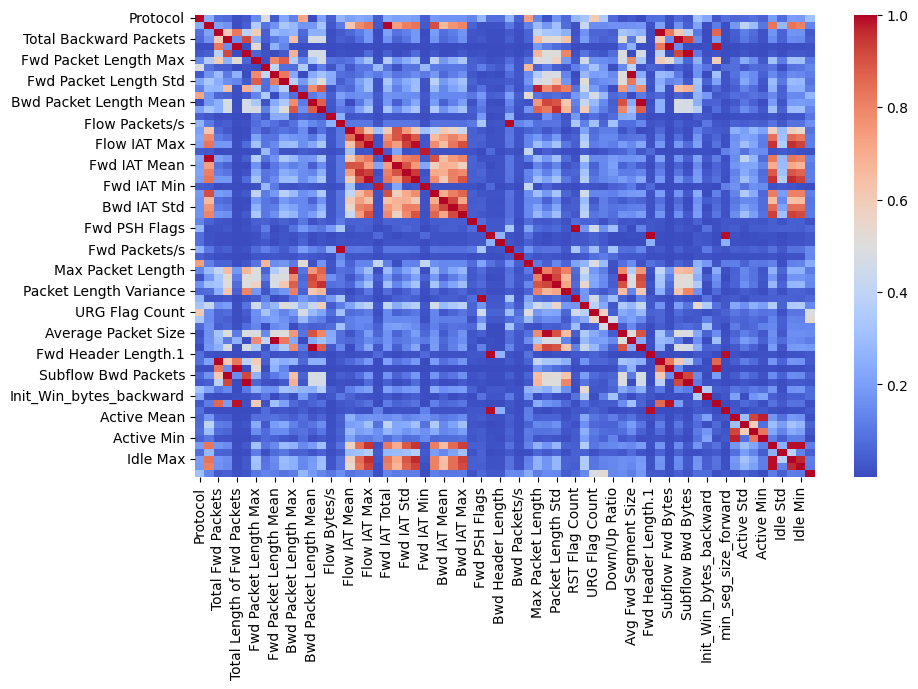

In [92]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.show()

<p>Aqui é criado a parte superior da matriz de correlação, excluindo a diagonal, para facilitar a identificação de variáveis altamente correlacionadas entre si.</p>

In [93]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.shape

(66, 66)

<p>Aqui será identificado e selecionado as colunas mais altamente correlacionadas (correlação maior que 0.9) e remover uma delas com base na variância (a que tiver menor variância).</p>

In [94]:
to_drop = []

for column in upper.columns:
    high_corr = upper[column][upper[column] > 0.9].index.tolist()
    for correlated_column in high_corr:
        var_column = X_benign[column].var()
        var_correlated = X_benign[correlated_column].var()

        if var_column < var_correlated:
            to_drop.append(column)
        else:
            to_drop.append(correlated_column)


In [95]:
to_drop = list(set(to_drop))

print(f'Colunas que serão removidas por correlação + baixa variância: {to_drop}')

Colunas que serão removidas por correlação + baixa variância: ['Idle Max', 'Packet Length Std', 'Bwd IAT Max', 'Total Backward Packets', 'Fwd IAT Max', 'Flow IAT Min', 'Flow IAT Std', 'Bwd Packet Length Mean', 'Idle Mean', 'Bwd IAT Std', 'Average Packet Size', 'Bwd IAT Mean', 'Total Length of Bwd Packets', 'Bwd IAT Total', 'Packet Length Mean', 'Total Fwd Packets', 'Fwd Header Length', 'Fwd IAT Std', 'Subflow Bwd Packets', 'Bwd Packet Length Max', 'act_data_pkt_fwd', 'min_seg_size_forward', 'Total Length of Fwd Packets', 'Idle Min', 'Fwd IAT Total', 'Active Min', 'Fwd PSH Flags', 'Fwd Packets/s', 'Active Mean', 'Fwd Packet Length Mean']


In [96]:
X_reduced_corr = X_benign.drop(columns=to_drop)

In [97]:
X_reduced_corr.shape

(31616, 49)

In [98]:
X_reduced_corr

,Protocol,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Fwd IAT Mean,Fwd IAT Min,Bwd IAT Min,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Bwd Header Length,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Std,Active Max,Idle Std,Inbound
0,6,1,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.000000e+06,1.000000e+00,1.0,1.000000e+00,1.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,56,0,0,0,0,0,0,2,0,0,8192,-1,0.000000e+00,0.0,0.000000e+00,1
1,6,266,46.0,0.0,18.780309,0.0,0.000000,578947.368421,1.879699e+04,6.650000e+01,263.0,6.650000e+01,1.0,0.0,0,0,0,0,0.000000,0.0,46.0,320.666667,0,0,1,0,0,1,0,0,0.0,30.800000,0.000000,100,0,0,0,0,0,0,5,154,0,256,-1,0.000000e+00,0.0,0.000000e+00,0
2,6,20637,0.0,0.0,0.000000,0.0,16.979399,3004.312642,2.907399e+02,4.127400e+03,20632.0,0.000000e+00,0.0,1.0,0,0,0,100,242.283278,0.0,31.0,228.809524,0,0,0,0,0,1,1,0,5.0,0.000000,12.400000,20,0,0,0,0,0,0,1,0,62,256,254,0.000000e+00,0.0,0.000000e+00,0
3,6,148,0.0,0.0,0.000000,0.0,0.000000,0.000000,2.027027e+04,7.400000e+01,147.0,0.000000e+00,0.0,1.0,0,0,0,40,13513.513514,0.0,0.0,0.000000,0,0,0,0,0,1,1,0,2.0,0.000000,0.000000,20,0,0,0,0,0,0,1,0,0,254,0,0.000000e+00,0.0,0.000000e+00,1
4,0,113580323,0.0,0.0,0.000000,0.0,0.000000,0.000000,3.697824e-01,2.770252e+06,9958914.0,2.770252e+06,1.0,0.0,0,0,0,0,0.000000,0.0,0.0,0.000000,0,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0,0,0,0,0,0,0,42,0,0,-1,-1,1.199478e+06,4155120.0,1.172700e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31611,17,20710,35.0,35.0,0.000000,83.0,0.000000,11395.461130,1.931434e+02,6.903333e+03,20663.0,1.000000e+00,1.0,46.0,0,0,0,40,96.571704,35.0,83.0,691.200000,0,0,0,0,0,0,0,0,1.0,35.000000,83.000000,40,0,0,0,0,0,0,2,70,166,-1,-1,0.000000e+00,0.0,0.000000e+00,0
31612,6,57104,440.0,0.0,227.215023,0.0,406.921450,43009.246287,2.101429e+02,5.191273e+03,27995.0,5.677400e+03,1.0,1.0,0,0,0,144,105.071449,0.0,788.0,97091.076923,0,0,0,0,1,0,0,0,1.0,146.666667,262.666667,144,0,0,0,0,0,0,6,880,1576,8192,288,0.000000e+00,0.0,0.000000e+00,0
31613,17,20565,36.0,36.0,0.000000,52.0,0.000000,8558.230002,1.945052e+02,6.855000e+03,20561.0,2.000000e+00,2.0,2.0,0,0,0,64,97.252614,36.0,52.0,76.800000,0,0,0,0,0,0,0,0,1.0,36.000000,52.000000,64,0,0,0,0,0,0,2,72,104,-1,-1,0.000000e+00,0.0,0.000000e+00,0
31614,6,57117,440.0,0.0,227.215023,0.0,406.921450,42999.457254,2.100951e+02,5.192455e+03,28040.0,5.694600e+03,1.0,1.0,0,0,0,144,105.047534,0.0,788.0,97091.076923,0,0,0,0,1,0,0,0,1.0,146.666667,262.666667,144,0,0,0,0,0,0,6,880,1576,8192,288,0.000000e+00,0.0,0.000000e+00,0


<h2 style="color: rgb(100, 200, 34);">Normalização dos Dados</h2>

<p>Tratar os dados do dataset a fim de possuir apenas valores dentro de um intervalo específico.</p>

<p>Fazer o Hold-Out antes da normalização, a fim de evitar data leak</p>

In [99]:
X_reduced_corr.shape

(31616, 49)

<p>Divide o dataset para teste (30%) e treino (70%)</p>

In [100]:
X_train, X_val, y_train, y_val = train_test_split(X_reduced_corr, y_benign, test_size=0.3, random_state=42, stratify=y_benign)

In [101]:
top_features = X_train.columns 
top_features

Index(['Protocol', 'Flow Duration', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Bwd Header Length', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
       'Down/Up Ratio', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_byte

In [102]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[-0.69908153, -0.30815722, -0.23512385, ..., -0.15598039,
        -0.09463173, -0.45436057],
       [ 1.27263891, -0.30890326, -0.24291652, ..., -0.15598039,
        -0.09463173, -0.45436057],
       [-0.69908153, -0.31010289, -0.35461138, ..., -0.15598039,
        -0.09463173, -0.45436057],
       ...,
       [ 1.27263891, -0.31080995, -0.27928229, ..., -0.15598039,
        -0.09463173, -0.45436057],
       [-0.69908153,  3.93251945,  0.77792259, ...,  0.32681527,
        -0.06220426, -0.45436057],
       [-0.69908153, -0.3022812 , -0.23512385, ..., -0.15598039,
        -0.09463173, -0.45436057]], shape=(22131, 49))

In [103]:
X_val_scaled = scaler.transform(X_val)

In [104]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)

In [105]:
X_train_scaled_df.shape

(22131, 49)

In [106]:
X_train_scaled_df.columns

Index(['Protocol', 'Flow Duration', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Std',
       'Bwd Packet Length Min', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Fwd IAT Mean',
       'Fwd IAT Min', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Bwd Header Length', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',
       'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count',
       'Down/Up Ratio', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
       'Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk',
       'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk',
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
       'Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       'Init_Win_byte

In [107]:
X_test_final = X_test_final[top_features]

In [108]:
X_test_final_scaled = scaler.transform(X_test_final)

In [109]:
X_test_final_scaled_df = pd.DataFrame(X_test_final_scaled, columns=top_features, index=X_test_final.index)

In [110]:
X_test_final_scaled_df.shape

(74118, 49)

In [111]:
X_test_final_scaled_df.head()

,Protocol,Flow Duration,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Std,Bwd Packet Length Min,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Max,Fwd IAT Mean,Fwd IAT Min,Bwd IAT Min,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Bwd Header Length,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,Active Std,Active Max,Idle Std,Inbound
0,-0.699082,0.018382,-0.354611,-0.415765,-0.320497,-0.596970,-0.293785,-0.077700,-0.342837,1.424913,0.198691,0.968661,-0.056287,-0.319031,0.0,0.0,0.0,0.062001,-0.070537,-0.564447,-0.274775,-0.096025,0.0,-0.061356,-0.387788,0.0,2.180090,-0.856260,-0.492632,0.0,-0.961359,-0.454774,-0.403540,0.062669,0.0,0.0,0.0,0.0,0.0,0.0,-0.022202,-0.198463,-0.044590,0.020244,-0.325045,-0.115168,4.564862,-0.094632,2.200895
1,-1.774565,3.842178,-0.354611,-0.415765,-0.320497,-0.596970,-0.293785,-0.077700,-0.342837,1.825800,0.514531,1.265111,-0.056287,-0.319031,0.0,0.0,0.0,0.062001,-0.070537,-0.564447,-0.274775,-0.096025,0.0,-0.061356,-0.387788,0.0,-0.458697,-0.856260,-0.492632,0.0,-0.961359,-0.454774,-0.403540,0.062668,0.0,0.0,0.0,0.0,0.0,0.0,2.213870,-0.198463,-0.044590,-0.448399,-0.325045,-0.115008,-0.155814,0.082661,-0.454361
2,-0.699082,1.761257,6.910750,-0.268966,6.951919,-0.596970,0.384698,-0.077693,-0.342837,0.810446,0.522764,1.293253,-0.056287,-0.167875,0.0,0.0,0.0,0.062005,-0.070529,-0.564447,1.868415,0.601034,0.0,-0.061356,-0.387788,0.0,-0.458697,1.167869,-0.492632,0.0,-0.961359,6.779738,0.044093,0.062672,0.0,0.0,0.0,0.0,0.0,0.0,0.950003,5.134748,-0.028514,-0.433984,-0.248483,0.480040,0.297609,0.622592,-0.454361
3,1.272639,-0.310797,-0.271490,0.367162,-0.320497,1.452749,-0.293785,-0.077372,-0.342473,-0.280138,-0.285607,-0.297169,-0.056287,-0.167875,0.0,0.0,0.0,0.062001,-0.068747,0.552109,-0.176695,-0.092310,0.0,-0.061356,-0.387788,0.0,-0.458697,-0.856260,-0.492632,0.0,0.060830,-0.098191,0.108041,0.062668,0.0,0.0,0.0,0.0,0.0,0.0,-0.216643,-0.178242,-0.043059,-0.448399,-0.325045,-0.115168,-0.155980,-0.094632,-0.454361
4,-0.699082,1.761810,-0.339026,-0.268966,-0.320497,-0.596970,-0.293785,-0.077700,-0.342837,1.864430,0.523447,2.762153,-0.056291,-0.016720,0.0,0.0,0.0,0.062004,-0.070533,-0.564447,-0.270177,-0.096013,0.0,-0.061356,-0.387788,0.0,-0.458697,1.167869,-0.492632,0.0,-0.961359,-0.387914,-0.403540,0.062670,0.0,0.0,0.0,0.0,0.0,0.0,0.366680,-0.171923,-0.044590,-0.433870,-0.298451,-0.114120,-0.111407,0.684119,-0.454361


In [112]:
y_test_final.value_counts()

Label
0    59295
1    14823
Name: count, dtype: int64

<h2 style="color: rgb(100, 200, 34);">Treinamento do Isolation Forest</h2>

<p>Aqui será feito o treinamento do modelo.</p>

In [113]:
X_train_scaled_df.shape

(22131, 49)

In [590]:
model = IsolationForest(max_samples=0.9, n_estimators=150, contamination=0.02, random_state=42)
model.fit(X_train_scaled_df)

,n_estimators,150
,max_samples,0.9
,contamination,0.02
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


In [591]:
model.n_features_in_

49

<h2 style="color: rgb(100, 200, 34);">Predições</h2>

In [592]:
y_pred_val = model.predict(X_val_scaled_df)

In [593]:
y_pred_val = np.where(y_pred_val == -1, 1, 0)

In [594]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], shape=(9485,))

In [595]:
X_attacks = df_malign.drop('Label', axis=1)

In [596]:
X_attacks.replace([np.inf, -np.inf], np.nan, inplace=True)

In [597]:
X_attacks.fillna(X_attacks.mean(), inplace=True)

In [598]:
X_attacks.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
31616,17,1,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,2.944000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2000000.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,0,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31617,17,0,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.086726e+09,1.303158e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,0.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31618,17,1,2,0,2656.0,0.0,1328.0,1328.0,1328.0,0.0,0.0,0.0,0.0,0.0,2.656000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2000000.0,0.0,1328.0,1328.0,1328.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,1992.0,1328.0,0.0,0,0,0,0,0,0,0,2,2656,0,0,-1,-1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31619,17,1,2,0,2896.0,0.0,1448.0,1448.0,1448.0,0.0,0.0,0.0,0.0,0.0,2.896000e+09,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,2000000.0,0.0,1448.0,1448.0,1448.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2172.0,1448.0,0.0,-2,0,0,0,0,0,0,2,2896,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
31620,17,0,2,0,2944.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0.0,0.0,0.0,1.086726e+09,1.303158e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2,0,0.0,0.0,1472.0,1472.0,1472.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,2208.0,1472.0,0.0,-2,0,0,0,0,0,0,2,2944,0,0,-1,-1,1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [599]:
X_attacks_selected = X_attacks[top_features]
X_attacks_scaled = scaler.transform(X_attacks_selected)

In [600]:
X_attacks_scaled_df = pd.DataFrame(X_attacks_scaled)
X_attacks_scaled = X_attacks_scaled_df.sample(frac=0.3, random_state=42)

In [601]:
X_attacks_scaled.shape

(2369, 49)

In [602]:
X_val_scaled.shape

(9485, 49)

In [603]:
X_val_total = np.vstack((X_val_scaled, X_attacks_scaled))
y_val_total = np.concatenate((np.zeros(len(X_val_scaled)), np.ones(len(X_attacks_scaled))))

In [604]:
X_val_total.shape

(11854, 49)

<h2 style="color: rgb(100, 200, 34);">Métricas</h2>

In [605]:
y_val.isna().sum()

np.int64(0)

In [606]:
y_pred_val

array([0, 0, 0, ..., 0, 0, 0], shape=(9485,))

In [607]:
y_pred_val = model.predict(X_val_total)

c:\data_science_iforest_ddos\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [608]:
y_pred_val = np.where(y_pred_val == 1, 0, 1) 

In [609]:
y_pred_val

array([0, 0, 0, ..., 1, 1, 1], shape=(11854,))

In [610]:
predict_syn = classification_report(y_val_total, y_pred_val, digits=4)
print(predict_syn)

              precision    recall  f1-score   support

         0.0     0.9818    0.9806    0.9812      9485
         1.0     0.9227    0.9274    0.9251      2369

    accuracy                         0.9700     11854
   macro avg     0.9523    0.9540    0.9531     11854
weighted avg     0.9700    0.9700    0.9700     11854



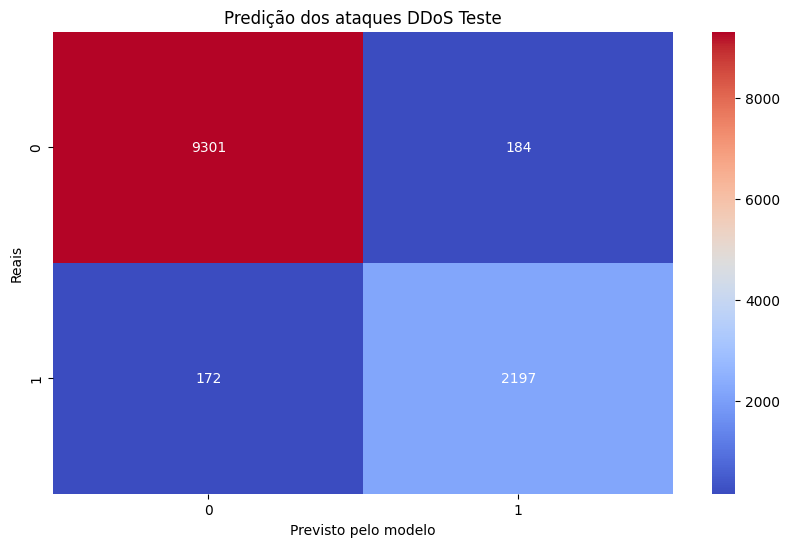

In [611]:
cm = confusion_matrix(y_val_total, y_pred_val)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Predição dos ataques DDoS Teste')
plt.xlabel('Previsto pelo modelo')
plt.ylabel('Reais')
plt.show()

In [612]:
um, zero = 0, 0
for i in y_val_total:
    if i == 0:
        zero += 1
    else:
        um += 1

print(zero, um)

9485 2369


In [613]:
y_test_final.value_counts()

Label
0    59295
1    14823
Name: count, dtype: int64

<h2 style="color: rgb(100, 200, 34);">Validação Final Externa</h2>

<p>Aqui será usado um dataset externo do CIC-DDoS2019 para validar e provar a generalização do projeto.</p>

In [614]:
y_pred_test = model.predict(X_test_final_scaled_df)

In [615]:
y_pred_test

array([ 1,  1, -1, ...,  1, -1, -1], shape=(74118,))

In [616]:
y_pred_test = np.where(y_pred_test == -1, 1, 0)


In [617]:
y_pred_test

array([0, 0, 1, ..., 0, 1, 1], shape=(74118,))

In [618]:
y_val.isna().sum()

np.int64(0)

In [619]:
y_pred_test

array([0, 0, 1, ..., 0, 1, 1], shape=(74118,))

In [620]:
y_test_final

0        0
1        0
2        0
3        0
4        0
        ..
74113    1
74114    1
74115    1
74116    1
74117    1
Name: Label, Length: 74118, dtype: int64

In [621]:
predict_syn = classification_report(y_test_final, y_pred_test, digits=4)
print(predict_syn)

              precision    recall  f1-score   support

           0     0.9185    0.9630    0.9402     59295
           1     0.8165    0.6582    0.7289     14823

    accuracy                         0.9021     74118
   macro avg     0.8675    0.8106    0.8346     74118
weighted avg     0.8981    0.9021    0.8980     74118



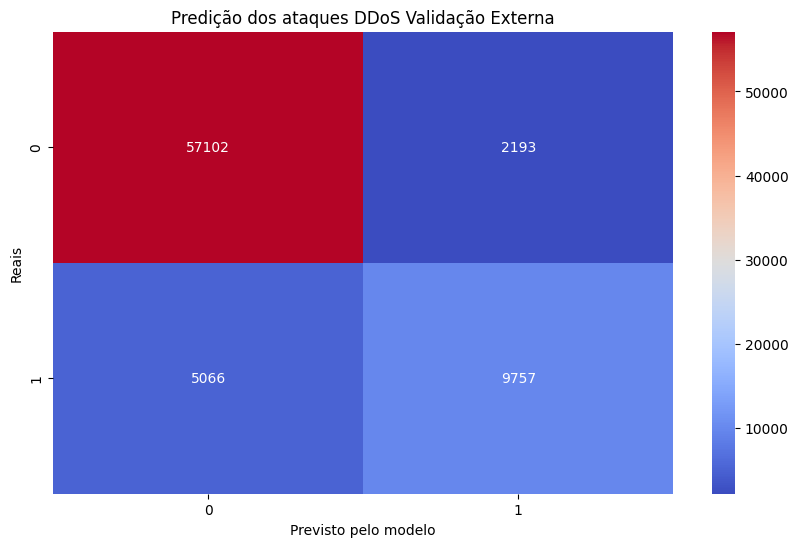

In [622]:
cm = confusion_matrix(y_test_final, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.title('Predição dos ataques DDoS Validação Externa')
plt.xlabel('Previsto pelo modelo')
plt.ylabel('Reais')
plt.show()

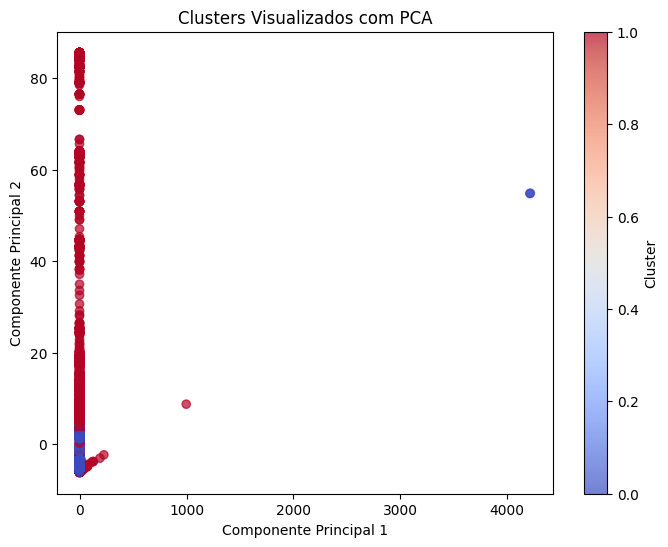

In [623]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test_final_scaled_df)

plt.figure(figsize=(8,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred_test,cmap='coolwarm', alpha=0.7)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters Visualizados com PCA')
plt.colorbar(label='Cluster')
plt.show()


<p>Ao final pode-se perceber que o modelo se aprendeu corretamento os dados ao manter sua acurácia ao decorrer do projeto inteiro.</p>